In [14]:
from tensorflow import keras
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(50, activation = "selu")
])

decoder = keras.models.Sequential([
    keras.layers.Dense(28 * 28,activation = "selu" ,input_shape=[50]),
    keras.layers.Reshape((28, 28, 1))
])
autoencoder = keras.models.Sequential([encoder,decoder])

autoencoder.compile(loss = "mse", optimizer = keras.optimizers.SGD(learning_rate = 0.1))

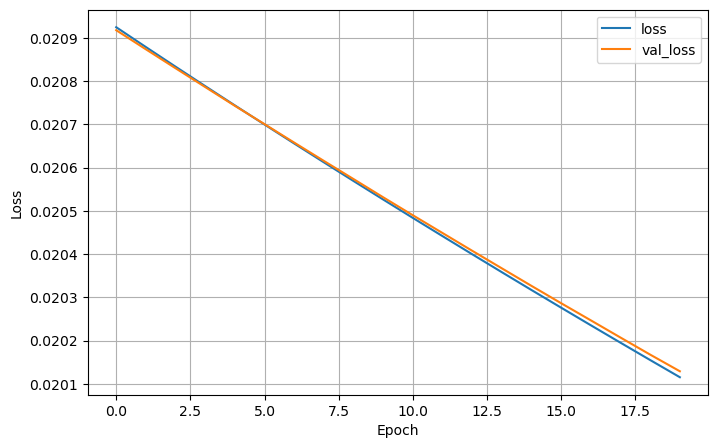

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0201 - val_loss: 0.0201
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [17]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Carrega o dataset MNIST (somente imagens de treino)
(X_train, _), _ = keras.datasets.mnist.load_data()

# Normaliza os valores para o intervalo [0, 1]
X_train = X_train.astype("float32") / 255.0

# Adiciona uma dimensão para representar o canal (transforma de (28, 28) para (28, 28, 1))
X_train = np.expand_dims(X_train, axis=-1)

# Verifica o shape final
print(X_train.shape)  # Deve ser (60000, 28, 28, 1)


class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        clear_output(wait=True)
        plt.figure(figsize=(8,5))
        plt.plot(self.losses, label='loss')
        plt.plot(self.val_losses, label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# Uso no fit:
plot_losses = PlotLosses()

history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    callbacks=[plot_losses]
)

# Gera os codings após o treinamento
codings = encoder.predict(X_train)

In [26]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        input_dim = self.dense.weights[0].shape[0]  # primeira dimensão dos pesos (input_dim)
        self.biases = self.add_weight(
            name="bias",
            initializer="zeros",
            shape=(input_dim,),
        )
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [29]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),  # <-- Corrigido aqui
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape((28, 28, 1))
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])